#  Investigation of access to green as a function of socioeconomic status

The NYC trees are surveyed periodically in the tree census by the NYC parks department. The [latest trees census](https://www.nycgovparks.org/trees/treescount) (the third) occurred between 2015 and 2016. 

Studies show that access to vegetation has positive physical and psychological health effects on citizens in urban environments, but access to green is generally uneven in different areas of a city. Often more vulnerable sections of the city population (socioe-conomically disadvantaged areas and predominantly minority areas) have less access to natural resources. See for example [this study](
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0122051)

This analysis is designed to test the hypothesis that diversity is correlated with access to green resources in NYC. 

The genral idea is that trees may not be distributed or mainteined in an equitable way by the City. 

First hint: the data download may take some time - Start downloading the data as soon as possible.



# Objective: assessing equity in NYC greenery distribution by relating access to greenery to diversity

PLEASE SEE THE HINTS TO EACH TASK [here](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit?usp=sharing) (no points loss for hints!)

You will receive points for each of the marked deliverables, *and for your discussion of your findings*. 

## 1-6 are the data wrangling portion of the exercise, and are worth up to 60% of the points
*In the data wrangling portion points are awarded for data processed so that they support the analysis in parts 5-10. This portion is likely going to be the most time consuming.*

## 7-11 are the analysis portion of the exercise (including exploratory and visual analysis), and are worth up to 50% of the points 
*In the data analysis portion points are awarded for correct analysis, conclusions supported by the analysis *and expressed in full sentences*, and plots that support the analysis and conclusions.*

*That sums up to 110%, but the maximum grate is reached at 100%. This means you have a better chance to get 100% on your test, and if you exceed 100% the rest will be accounted for as extra credit and help your cumulative score at the end of the semester.*

## Data Wrangling (each task is 10% of the points)
    1. Download 2015 tree census data data and subsample it to reduce it to a manageable size including only the Manhattan trees (solution for this step is available)

    2. Download Download socioeconomic features: ACS 2016 race and ethnicity information for Manhattan aggregated at the Zipcode level (solution for this step is available). 
 
    3. Download a NYC (Mahnattan) ZIPCODE shapefile. 
    
    4. Identify the column from the tree census file that describes health of trees.  What kind of variable is this? Remake the plot in step 1 colorcoding the trees by kind of problem. 
    
    5.  Group the tree dataframe by zipcode and calculate theaverage tree health and number of trees per zipcode (solution for this step is available).
    
    6. Data aggregation task: join the zipcode geodataframe with the population diversity data and with the zipcode level tree statistics. Calculate the number of trees per person by zipcode (solution for this step is available).


## Analysis (visual and quantitative)

    7. Make a map for each of the variables: population diversity, number of trees per person, average tree health.
   
    8. Plot the distribution of trees per person, the tree health, and population diversity by zipcode

    9. Assess which of these distributions is most consistent with a Gaussian.
   
    10. Measure correlation between number of trees per person and population diversity and between tree health and population diversity
    
    11. Based on the result in 10, choose either tree health or trees per person and assess if the distribution of this variable is consistent with the population diversity with a p-value based test.

    
    ExtraCredit:  A more appropriate analysis would be an analysis of the spatial correlation of these variables. Measure the spatial correlation of number of trees per person and/or of tree health with the population diversity

In [160]:
from __future__ import print_function
__author__= 'Pablo Mandiola'

import os

#Data handling
import numpy as np
import pandas as pd

#Spatial data handling
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

#Downloading
try:
    import urllib2 as urlib
except ImportError:
    import urllib as urlib
import requests

#Additional imports for SQL
try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError
    
import ast

#Statistics
import scipy as sp

#For plotting
import matplotlib.pylab as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.2, rc=None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/data/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/pmb434/PUIdata


## 1. Download trees data for the 2015 treea census. (10%)

Data can be accessed from the NYC data portal here [this link](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh) for a table or [this link](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35) for a map/shapefile.

Accessing it through the SODA API as a csv file is probably the most straightforward way.
[hints](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit?usp=sharing)

Note that the file is large, and will take some time to read! Start the download right away and then go back to the instructions. 
You can download the shapefile (large and bandwidth demanding) or a csv (not a geospatial file) and then transform it to a shapefile (you did it in HW 7).
If you need help [refer to the hints](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit?usp=sharing). 

(Don't forget to move the file to $PUIDATA!)
 
Very important! this dataset is large! over 500k rows! to plot the whole dataset it took me 1/2 minute on the ADRF. 

Modify your dataframe/geodataframe and select the Manhattan trees only.


_Deliverable: a map like the one below._

You can find the solution [here](https://serv.cusp.nyu.edu/~fbianco/manTrees.csv) - if you use this solution you will not get the 10 points for this deliverable (but you can go back later to this! and if you do get the solution later you will get the points!). However, this is just a csv file, and to plot it you will still need to create the point coordinates and convert the file to a GeoDataFrame (you did it in HW 7) which will earn you 3 points

[hints](https://docs.google.com/document/d/1i9wL8V9jAmyEB7DI309IGtMYXbD4ITlrZhGQyjRaJpI/edit?usp=sharing)

In [32]:
#Set url and filename for generated file
url = 'https://data.cityofnewyork.us/api/views/uvpi-gqnh/rows.csv?accessType=DOWNLOAD'
filename = '2015_Street_Tree_Census_-_Tree_Data.csv'

#Check if file exists
if not os.path.isfile(puidata + "/" + filename):
    print ("Downloading file")
    #Use this for some reason instead of curl, maybe because the url doesn't point to a file but generates it
    urlib.request.urlretrieve(url, filename)
    os.system("mv " + filename + " " + puidata)


if not os.path.isfile(puidata + "/" + filename):
    print('Warning: file is not there, something went wrong!')
else:
    print('Files in place, please continue')

Files in place, please continue


In [33]:
nycTrees = pd.read_csv(puidata + '/' + filename)
nycTrees.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


In [35]:
nycTrees.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl'],
      dtype='object')

In [39]:
manTrees = nycTrees.loc[nycTrees.borough == 'Manhattan']

In [40]:
#Combine lat long into a tuple column
manTrees['lonlat'] = list(zip(manTrees.longitude, manTrees.latitude))
#Create Point feature in geometry column
manTrees['geometry'] = manTrees.lonlat.apply(lambda x: shapely.geometry.Point(x))
#Create GeoDataFrame
manTrees = gpd.GeoDataFrame(manTrees)
#Set CRS
manTrees.crs = from_epsg(4326)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
#leave
manTrees.shape

(65423, 47)

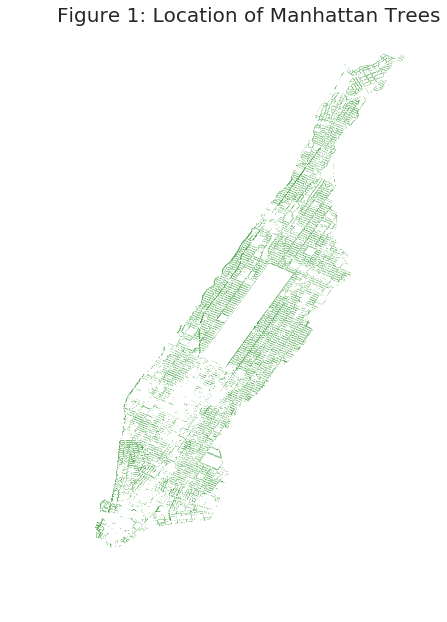

In [210]:
#leave 
ax = manTrees.plot(markersize=0.01, color='green', figsize=(10,10))
ax.set_title("Figure 1: Location of Manhattan Trees", fontsize=20)
ax.set_ylabel("latitude", fontsize=20)
ax.set_xlabel("longitude", fontsize=20);
plt.axis("off")
plt.show()

# 2 Download race and ethnicity information from ACS 2016 for Manhattan aggregate at the Zipcode level. 

You can start from scratch from [American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml). You can obtain the data through the API directly or prepare the file online at the American Fact Finder site and download it, then upload it to the ADRF (as instructed in HW7). This is time consuming if you are not very familiar with this portal.

Alternatively you can choose to download the data with an SQL query from the dta that I uploaded  at https://nyu.carto.com/u/fb55/dataset/acs16  (same points). This is the same kind of SQL query you used in the databases homework (HW6)

Measure diversity as percentage of non-white population by zipcode. 

*_Deliverable: a table as the one below which contains the total population by zipcode and the fraction of non white popultion_* 

(small differences may occurr dependeing on how you get the data and source it. You do not need to have an error column, but I could not help myself...)


You can find the solution [here](https://serv.cusp.nyu.edu/~fbianco/acs16_final.csv) - if you use this solution you will not get the 10 points for this deliverable (but you can go back later to this! and if you do get the solution later you will get the points!). 

[hints](https://docs.google.com/document/d/1Ps_jXCOdxZyNspVOHdKHbPQWf8WiLTI0bQccMMgNUU8/edit?usp=sharing)

In [3]:
#API URL
API_URL = 'https://fb55.carto.com:443/api/v2/sql?q='

#Query function
def queryCartoDB(query, formatting = 'CSV', source = API_URL):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

In [219]:
query = '''SELECT * FROM fb55.acs16; '''
acs16 = get_data(query)
acs16.head(10)

,the_geom,hd02_vd04,the_geom_webmercator,geo_id,geo_id2,geo_display_label,hd01_vd01,hd02_vd01,hd01_vd02,hd02_vd02,...,hd01_vd06,hd02_vd06,hd01_vd07,hd02_vd07,hd01_vd08,hd02_vd08,hd01_vd09,hd02_vd09,hd01_vd10,hd02_vd10
0,NaN,11,NaN,8600000US10464,10464,ZCTA5 10464,4300,587,3262,560,...,0,11,733,439,27,30,2,4,25,29
1,NaN,11,NaN,8600000US10910,10910,ZCTA5 10910,27,41,27,41,...,0,11,0,11,0,11,0,11,0,11
2,NaN,11,NaN,8600000US11430,11430,ZCTA5 11430,179,161,16,30,...,0,11,27,44,7,14,7,14,0,11
3,NaN,11,NaN,8600000US14511,14511,ZCTA5 14511,334,191,316,179,...,0,11,0,11,18,27,0,11,18,27
4,NaN,Margin of Error; Total: - American Indian and ...,NaN,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Total: - White alone,Margin of Error; Total: - White alone,...,Estimate; Total: - Native Hawaiian and Other P...,Margin of Error; Total: - Native Hawaiian and ...,Estimate; Total: - Some other race alone,Margin of Error; Total: - Some other race alone,Estimate; Total: - Two or more races:,Margin of Error; Total: - Two or more races:,Estimate; Total: - Two or more races: - Two ra...,Margin of Error; Total: - Two or more races: -...,Estimate; Total: - Two or more races: - Two ra...,Margin of Error; Total: - Two or more races: -...
5,NaN,1662,NaN,0500000US36061,36061,"New York County, New York",1634989,*****,928883,5432,...,946,202,192292,6079,69335,3324,15444,1849,53891,2915
6,NaN,11,NaN,8600000US06390,06390,ZCTA5 06390,303,151,297,150,...,0,11,0,11,6,14,6,14,0,11
7,NaN,235,NaN,8600000US07421,07421,ZCTA5 07421,7281,512,6547,535,...,0,17,215,251,86,59,23,35,63,46
8,NaN,34,NaN,8600000US10001,10001,ZCTA5 10001,23332,1740,14814,1045,...,0,21,640,541,611,218,230,154,381,150
9,NaN,138,NaN,8600000US10002,10002,ZCTA5 10002,78096,2456,24591,1682,...,8,12,10432,1623,2879,623,565,228,2314,561


In [220]:
acs16 = acs16.drop(4)

In [225]:
acs16 = acs16.loc[:,['geo_id2','hd01_vd01','hd01_vd02']]

In [226]:
acs16.rename(columns={'geo_id2':'zipcode', 'hd01_vd01':'total', 'hd01_vd02':'white_total'}, inplace=True)

In [227]:
acs16.zipcode = acs16.zipcode.astype(int)
acs16.total = acs16.total.astype(int)
acs16.white_total = acs16.white_total.astype(int)

In [228]:
acs16['non_whiteFraction'] = (acs16.total - acs16.white_total)/acs16.total

In [229]:
acs16.sort_values('zipcode',axis=0,inplace=True)

In [231]:
acs16.head(10)

,zipcode,total,white_total,non_whiteFraction
6,6390,303,297,0.019802
7,7421,7281,6547,0.100810
8,10001,23332,14814,0.365078
9,10002,78096,24591,0.685118
10,10003,56767,44001,0.224884
11,10004,3044,2201,0.276938
12,10005,8710,6425,0.262342
13,10006,3277,2162,0.340250
14,10007,6740,4790,0.289318
15,10009,59799,36219,0.394321


There are some rows that are not zipcodes, that will be fixed when we merge

# 3 Download the a shapefile for zipcodes in NYC. 

_Deliverable: a plot like the one below_

[hints](https://docs.google.com/document/d/1VebStvoAoq4YAVgQJ7gRjSyy8cycszIdgT33zJze5zk/edit?usp=sharing)

In [21]:
#Set url and filename for generated file
url = 'https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
filename = 'ZIP_CODE_040114.zip'

#Check if file exists
if not os.path.isfile(puidata + "/" + filename):
    print ("Downloading file")
    #Use this for some reason instead of curl, maybe because the url doesn't point to a file but generates it
    urlib.request.urlretrieve(url, filename)
    os.system("mv " + filename + " " + puidata)

#Unzip file
print ("Unzipping file")
os.system("unzip " + puidata + "/" + filename + " -d " + puidata)

#Get the file names from the .zip
files = os.popen("unzip -Z1 " + puidata + "/" + filename).read()
files = files.split(sep='\n')
shp_file = files[1]

if not os.path.isfile(puidata + "/" + shp_file):
    print('Warning: file is not there, something went wrong!')
else:
    print('Files in place, please continue')

Unzipping file
Files in place, please continue


In [22]:
nycZipCodes = gpd.GeoDataFrame.from_file(puidata + '/' + shp_file)
nycZipCodes.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [25]:
manZipcodes = nycZipCodes.loc[nycZipCodes.COUNTY == 'New York']

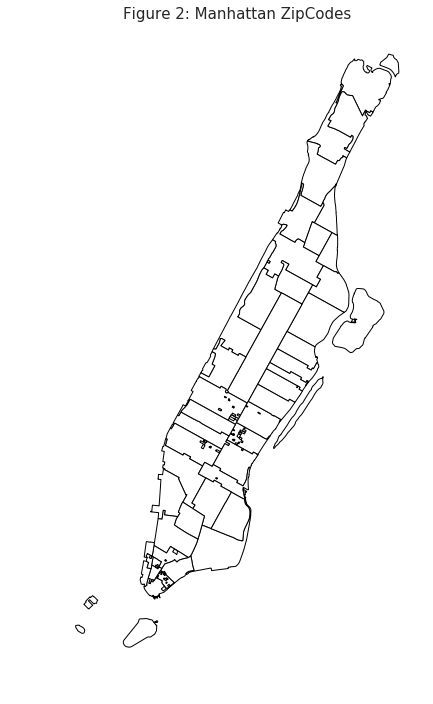

In [31]:
# using the built in plot function as pumashp.plot(pumashp....)
ax = manZipcodes.plot(color='white', edgecolor='black', figsize=(12,12), lw=1)
plt.axis('off')
ax.set_title('Figure 2: Manhattan ZipCodes', fontsize=15)
plt.show()

# 4. Identify the column from the trees file that describes health of trees    
    
What kind of variable is this? Remake the plot in step 1 colorcoding the trees by health. 

_Deliverable: a plot like the one in step 1 but colorcoded by tree health_

In [45]:
manTrees.columns

Index(['tree_id', 'block_id', 'created_at', 'tree_dbh', 'stump_diam',
       'curb_loc', 'status', 'health', 'spc_latin', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other', 'address', 'postcode',
       'zip_city', 'community board', 'borocode', 'borough', 'cncldist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp', 'council district',
       'census tract', 'bin', 'bbl', 'lonlat', 'geometry'],
      dtype='object')

In [47]:
manTrees.health.value_counts()

Good    47358
Fair    11460
Poor     3609
Name: health, dtype: int64

We can see that the health column is a string with 3 values: Good, Fair, and Poor. Its a categorical variable.

In [59]:
manTrees['health_int'] = manTrees.health.map({'Good':2,'Fair':1, 'Poor':0})

In [61]:
manTrees.health_int.value_counts()

2.0    47358
1.0    11460
0.0     3609
Name: health_int, dtype: int64

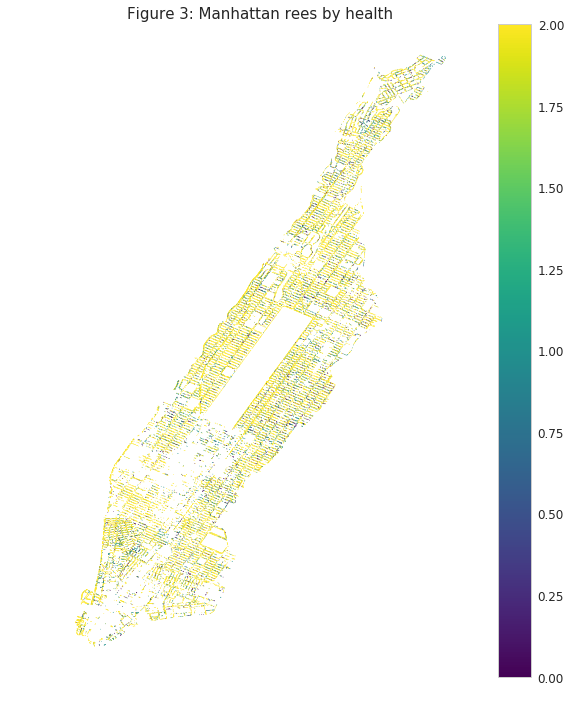

In [273]:
fig, ax = plt.subplots(figsize  = (12, 12))

ax.set_title("Figure 3: Manhattan rees by health", fontsize=15)

manTrees.plot(column='health_int', ax=ax, legend=True, cmap='viridis', markersize=0.1)

ax.axis('off')

#Correct aspect ratio
ax.axes.set_aspect('equal')

plt.show()

# 5 Group the tree dataframe by zipcode and calculate theaverage tree health and number of trees per zipcode.

_Deliverable: a dataframe containing zipcode and hree health, a dataframe containint zipcode and number of trees_

You can find the solution [here](https://serv.cusp.nyu.edu/~fbianco/ntrees.csv) and  [here](https://serv.cusp.nyu.edu/~fbianco/treehealth.csv) - if you use this solution you will not get the 10 points for this deliverable (but you can go back later to this! and if you do get the solution later you will get the points!)

[hints](https://docs.google.com/document/d/1saSbFb092U6AyJDU10yTzbKOQITKinyQlw2KcNWg2B4/edit?usp=sharing)

In [68]:
manTrees.rename(columns={'postcode':'zipcode'}, inplace=True)

In [73]:
ntrees = manTrees.groupby(by='zipcode')[['health']].count()
ntrees.reset_index(inplace=True)

In [94]:
ntrees.rename(columns={'health':'ntrees'}, inplace=True)

In [95]:
ntrees.head()

,zipcode,ntrees
0,83,932
1,10001,850
2,10002,2158
3,10003,1943
4,10004,117


In [76]:
treehealth = manTrees.groupby(by='zipcode')[['health_int']].mean()
treehealth.reset_index(inplace=True)

In [92]:
treehealth.rename(columns={'health_int':'treehealth'}, inplace=True)

In [93]:
treehealth.head()

,zipcode,treehealth
0,83,1.940987
1,10001,1.809412
2,10002,1.714087
3,10003,1.709213
4,10004,1.803419


# 6 Data aggregation task: 

merge the dataframes and geodataframes (trees, zipcodes, and ACS), group them so that each zipcode has 
1. the number of trees per person
2. the average tree health
3. the percentage of non-white population
4. the shape of the area (zipcode)

_Your deliverable for this task is a dataframe like the one below_

You can find the solution [here](https://serv.cusp.nyu.edu/~fbianco/treepp.csv) - if you use this solution you will not get the 10 points for this deliverable (but you can go back later to this! and if you do get the solution later you will get the points!)

[hints](https://docs.google.com/document/d/1EJnoZ3NWiUBOx4swbNMMdEA2c_mMOnr108ov79d26sM/edit?usp=sharing)

In [233]:
manZipcodes.ZIPCODE = manZipcodes.ZIPCODE.astype(int)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [234]:
treepp = manZipcodes.merge(treehealth,
                  right_on="zipcode",
                  left_on="ZIPCODE",
                  how='inner')

In [235]:
treepp = treepp.merge(acs16,
             right_on="zipcode",
                  left_on="ZIPCODE",
                  how='inner')

In [236]:
treepp = treepp.merge(ntrees,
             right_on="zipcode",
                  left_on="ZIPCODE",
                  how='inner')

In [237]:
treepp = treepp.loc[:,['ZIPCODE', 'geometry', 'total', 'non_whiteFraction', 'treehealth', 'ntrees']]

In [238]:
treepp.head()

,ZIPCODE,geometry,total,non_whiteFraction,treehealth,ntrees
0,10034,"POLYGON ((1006203.169008225 257345.6566181332,...",43951,0.603399,1.596282,1506
1,10033,"POLYGON ((1003020.86467731 256049.1618358046, ...",59353,0.586693,1.628510,1852
2,10040,"POLYGON ((1002564.135275811 253724.7731118798,...",45033,0.636866,1.627154,1451
3,10032,"POLYGON ((998935.8528342247 249154.259943217, ...",63189,0.684629,1.631274,2072
4,10031,"POLYGON ((1000830.038678393 241801.5896092206,...",60778,0.708957,1.727199,2456


In [239]:
treepp['treepp'] = treepp.ntrees/treepp.total

In [240]:
treepp.head()

,ZIPCODE,geometry,total,non_whiteFraction,treehealth,ntrees,treepp
0,10034,"POLYGON ((1006203.169008225 257345.6566181332,...",43951,0.603399,1.596282,1506,0.034265
1,10033,"POLYGON ((1003020.86467731 256049.1618358046, ...",59353,0.586693,1.628510,1852,0.031203
2,10040,"POLYGON ((1002564.135275811 253724.7731118798,...",45033,0.636866,1.627154,1451,0.032221
3,10032,"POLYGON ((998935.8528342247 249154.259943217, ...",63189,0.684629,1.631274,2072,0.032791
4,10031,"POLYGON ((1000830.038678393 241801.5896092206,...",60778,0.708957,1.727199,2456,0.040409


In [241]:
# final daaframe
treepp.head()

,ZIPCODE,geometry,total,non_whiteFraction,treehealth,ntrees,treepp
0,10034,"POLYGON ((1006203.169008225 257345.6566181332,...",43951,0.603399,1.596282,1506,0.034265
1,10033,"POLYGON ((1003020.86467731 256049.1618358046, ...",59353,0.586693,1.628510,1852,0.031203
2,10040,"POLYGON ((1002564.135275811 253724.7731118798,...",45033,0.636866,1.627154,1451,0.032221
3,10032,"POLYGON ((998935.8528342247 249154.259943217, ...",63189,0.684629,1.631274,2072,0.032791
4,10031,"POLYGON ((1000830.038678393 241801.5896092206,...",60778,0.708957,1.727199,2456,0.040409


In [245]:
treepp.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,ZIPCODE,total,non_whiteFraction,treehealth,ntrees,treepp
count,50.000000,50.00000,47.000000,50.000000,50.000000,50.000000
mean,10039.380000,33116.96000,0.403057,1.705934,1272.660000,inf
std,57.151746,24247.44354,0.232947,0.107324,929.716319,NaN
min,10001.000000,0.00000,0.110793,1.346154,7.000000,0.014648
25%,10011.250000,9724.25000,NaN,1.639039,368.250000,0.032404
50%,10024.500000,30310.00000,NaN,1.702118,1382.000000,0.038436
75%,10035.750000,50434.00000,NaN,1.803218,1881.000000,0.045247
max,10282.000000,94717.00000,0.892552,1.930435,3570.000000,inf


In [246]:
#I'm going to drop Nans and Infinity values
treepp.replace(np.inf, np.nan, inplace=True)
treepp.dropna(inplace=True)

# 7 Make a map for each of the variables: population diversity, number of trees per person, average tree health.

Each map should be a choropleth of the relevant variable.

_your deliverable is a series of 3 plots and appropriate comments_
(They do not have to be in a single line, and you do not need the zipcode one, but please try to pay as much attention as you can given the time constraints to your plot design. I chose to put them in a single line designing them as a "small multiple" plot like Tufte recommands)

[hints](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit#heading=h.174i5wa5g9nj)

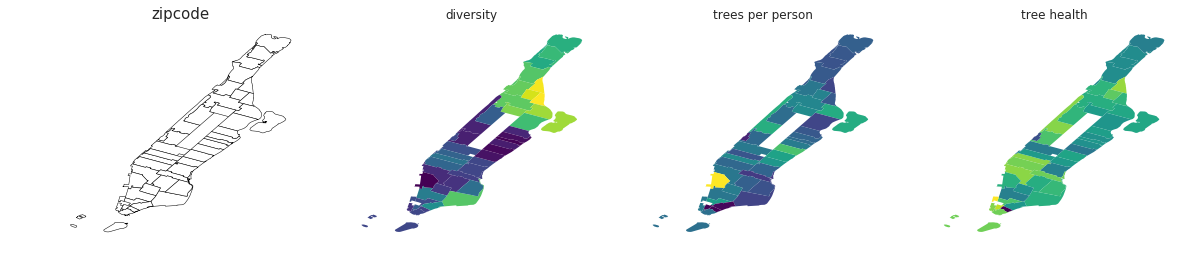

In [247]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize  = (20, 4))

#zipcode
treepp.plot(color='white', edgecolor='black', figsize=(12,12), lw=0.5, ax=ax1)
ax1.axis('off')
ax1.set_title('zipcode', fontsize=15)
ax1.axes.set_aspect('auto')

#diversity
treepp.plot(column='non_whiteFraction', ax=ax2, legend=False, cmap='viridis')

ax2.set_title("diversity", fontsize=12)
ax2.axis('off')
ax2.axes.set_aspect('auto')

#trees per person
treepp.plot(column='treepp', ax=ax3, legend=False, cmap='viridis')

ax3.set_title("trees per person", fontsize=12)
ax3.axis('off')
ax3.axes.set_aspect('auto')

#tree health
treepp.plot(column='treehealth', ax=ax4, legend=False, cmap='viridis')

ax4.set_title("tree health", fontsize=12)
ax4.axis('off')
ax4.axes.set_aspect('auto')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

#Correct aspect ratio

plt.show()

# 8 plot the distribution of tree numbers by area, tree average tree health, and population diversity by zipcode
Consider using this visualization to remove outliers if you see any [hint](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit#heading=h.174i5wa5g9nj)

_your deliverable is a series of 3 plots and appropriate comments_

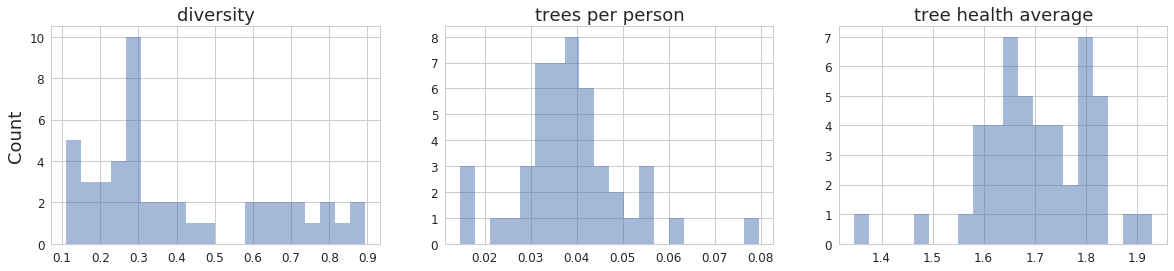

In [249]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize  = (20, 4))

ax1.set_ylabel('Count', fontsize=18)
#ax1.set_xlabel('Trip duration', fontsize=18)
ax1.set_title('diversity', fontsize=18)
ax1.hist(treepp.non_whiteFraction, alpha=0.5, bins=20)

ax2.set_title('trees per person', fontsize=18)
ax2.hist(treepp.treepp, alpha=0.5, bins=20)

ax3.set_title('tree health average', fontsize=18)
ax3.hist(treepp.treehealth, alpha=0.5, bins=20)

#ax.legend()

plt.show()

# 9  Assess which of these distributions is most consistent with a Gaussian.

You used statistical tests that answer the question "can you reject the null hypothesis that a sample comes from a Standard Normal distriobution?"  

You do not need to frame this as a null hypothesis rejection test, but you can use the same test to compare how close to a Gaussian distribution each distribution is. 

Your deliverable for this portion is a test reault (or the results of a few tests) and its interpretation that shows which of the three distributions is closer to a Gaussian

What does the fact that some of these features are highly non Gaussian tell you?

[hints](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit#heading=h.dk2we21e8881)

In [250]:
#Function to evaluate
def evalNullHypothesis(p, statistic, test, hypothesis=None,alpha=0.05):
    if hypothesis:
        print ("The Null Hypothesis that {}".format(hypothesis))
    else:
        print ("The Null Hypothesis")
    if p < alpha :
        print ("can be rejected at alpha = {}".format(alpha))
    else: 
        print ("cannot be rejected (p<0.05)")
    print ("with a {} statistics of {:.2f} and a p-value of {}".format(test, statistic, p))

In [251]:
non_whiteFraction = treepp.non_whiteFraction

In [252]:
#normalize data
non_whiteFraction_normalized = (non_whiteFraction.values - non_whiteFraction.values.mean()) / non_whiteFraction.values.std()

In [253]:
#Returns Statistics and P-value
sp.stats.kstest(non_whiteFraction_normalized, "norm")

KstestResult(statistic=0.2011474328583942, pvalue=0.03830570663945454)

In [254]:
#Null hypothesis
hypothesis = "the distribution of diversity by zipcode comes from a gaussian distribution"

#Get statistics
(ks, p) = sp.stats.kstest(non_whiteFraction_normalized, "norm")

#Test null hypothesis
evalNullHypothesis(p, ks, "KS", hypothesis)

The Null Hypothesis that the distribution of diversity by zipcode comes from a gaussian distribution
can be rejected at alpha = 0.05
with a KS statistics of 0.20 and a p-value of 0.03830570663945454


In [255]:
treepp_data = treepp.treepp

In [256]:
#normalize data
treepp_data_normalized = (treepp_data.values - treepp_data.values.mean()) / treepp_data.values.std()

In [257]:
#Returns Statistics and P-value
sp.stats.kstest(treepp_data_normalized, "norm")

KstestResult(statistic=0.1243274185775296, pvalue=0.43126911576435178)

In [258]:
#Null hypothesis
hypothesis = "the distribution of trees per person by zipcode comes from a gaussian distribution"

#Get statistics
(ks, p) = sp.stats.kstest(treepp_data_normalized, "norm")

#Test null hypothesis
evalNullHypothesis(p, ks, "KS", hypothesis)

The Null Hypothesis that the distribution of trees per person by zipcode comes from a gaussian distribution
cannot be rejected (p<0.05)
with a KS statistics of 0.12 and a p-value of 0.4312691157643518


In [259]:
treehealth_data = treepp.treehealth

In [260]:
#normalize data
treehealth_data_normalized = (treehealth_data.values - treehealth_data.values.mean()) / treehealth_data.values.std()

In [261]:
#Returns Statistics and P-value
sp.stats.kstest(treehealth_data_normalized, "norm")

KstestResult(statistic=0.099430807022598544, pvalue=0.74071392992846752)

In [262]:
#Null hypothesis
hypothesis = "the distribution of tree health by zipcode comes from a gaussian distribution"

#Get statistics
(ks, p) = sp.stats.kstest(treehealth_data_normalized, "norm")

#Test null hypothesis
evalNullHypothesis(p, ks, "KS", hypothesis)

The Null Hypothesis that the distribution of tree health by zipcode comes from a gaussian distribution
cannot be rejected (p<0.05)
with a KS statistics of 0.10 and a p-value of 0.7407139299284675


**ANSWER:** From the code above we can see that using a KS test of fitness, we get that only the distribution of diversity by zipcode is not Gaussian, with a significance of 0.05. This may indicate that the distribution of diversity across Manhattan zipcodes is biased.

# 10 Measure correlation between trees health and population diversity and the number of trees per person and population diversity
   
_your deliverable is a measure of correlation for each variable and an explanation of what they mean_



In [263]:
#Returns Statistics and P-value (needs to be sorted)
sp.stats.pearsonr(treepp.treehealth,treepp_nonan.non_whiteFraction)

(0.015839270598569998, 0.91584332018706083)

In [265]:
#Null hypothesis
hypothesis = "the distribution of trees health and population diversity are uncorrelated"

#Get statistics
(r, p) = sp.stats.pearsonr(treepp.treehealth,treepp.non_whiteFraction)

#Test null hypothesis
evalNullHypothesis(p, r, "Pearson r", hypothesis)

The Null Hypothesis that the distribution of trees health and population diversity are uncorrelated
cannot be rejected (p<0.05)
with a Pearson r statistics of 0.02 and a p-value of 0.9158433201870608


In [266]:
#Returns Statistics and P-value (needs to be sorted)
sp.stats.pearsonr(treepp.treepp,treepp.non_whiteFraction)

(-0.14853062961339925, 0.31905790557481517)

In [267]:
#Null hypothesis
hypothesis = "the distribution of number of trees per person and population diversity are uncorrelated"

#Get statistics
(r, p) = sp.stats.pearsonr(treepp.treepp,treepp.non_whiteFraction)

#Test null hypothesis
evalNullHypothesis(p, r, "Pearson r", hypothesis)

The Null Hypothesis that the distribution of number of trees per person and population diversity are uncorrelated
cannot be rejected (p<0.05)
with a Pearson r statistics of -0.15 and a p-value of 0.31905790557481517


# 11 Based on the result in 10, choose either tree health or trees per person and assess if the distribution of this variable is consistent with the population diversity.

This must be a test which returns a rejection (or non rejection) of a hypothesis. 

_your deliverable is Null hypothesis rejection test and a description of what it means_

[hints](https://docs.google.com/document/d/1a009HzGw_1j9dlqyD5Zg9aibUgpYmXMlJqiA5XUzZos/edit#heading=h.ehszhe99hr1l)

For some reason in 10, I got that they are not correlated for both cases, I'll choose the one with lower p-value.

In [268]:
#Returns Statistics and P-value
sp.stats.ks_2samp(treepp.treepp, treepp.non_whiteFraction)

Ks_2sampResult(statistic=1.0, pvalue=4.6758515658443521e-22)

In [269]:
#Null hypothesis
hypothesis = "the distribution of number of trees per person and population diversity come from the same parent distribution"

#Get statistics
(ks, p) = sp.stats.ks_2samp(treepp.treepp, treepp.non_whiteFraction)

#Test null hypothesis
evalNullHypothesis(p, ks, "KS", hypothesis)

The Null Hypothesis that the distribution of number of trees per person and population diversity come from the same parent distribution
can be rejected at alpha = 0.05
with a KS statistics of 1.00 and a p-value of 4.675851565844352e-22


# Based on all this analysis, what can you say about equity in distribution of trees? What are the weaknesses of the analysis? What could be done better?

# EC:  A more appropriate analysis would be an analysis of the spatial correlation of these variables. Measure the spatial correlation of number of trees per person and/or of tree health with the population diversity